#### Initialize the Spark 

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Gold").getOrCreate()

24/03/14 10:30:45 WARN Utils: Your hostname, Mansurs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.24 instead (on interface en0)
24/03/14 10:30:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/14 10:30:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/14 10:30:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/03/14 10:30:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/03/14 10:30:47 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/03/14 10:30:47 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
24/03/14 10:30:47 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attemp

#### Read the table

In [2]:
from pyspark.sql.types import StructType, StructField, StringType

# Define the schema for the locations_result table
locationsResultSchema = StructType([
    StructField("LocationId", StringType(), True),
    StructField("OrganisationID", StringType(), True),
    StructField("LocationPostCode_clean", StringType(), True),
    StructField("AreaName", StringType(), True),
    StructField("district", StringType(), True)
])

df = spark.read \
    .schema(locationsResultSchema) \
    .option("header", True) \
    .csv("Gold/locations_result.csv")
    
df.printSchema()
df.show(5,truncate=False)

root
 |-- LocationId: string (nullable = true)
 |-- OrganisationID: string (nullable = true)
 |-- LocationPostCode_clean: string (nullable = true)
 |-- AreaName: string (nullable = true)
 |-- district: string (nullable = true)

+------------------------------------+------------------------------------+----------------------+-----------------------+----------+
|LocationId                          |OrganisationID                      |LocationPostCode_clean|AreaName               |district  |
+------------------------------------+------------------------------------+----------------------+-----------------------+----------+
|8846a04e-c17d-4c49-9c0a-16ec3584fb95|26551569-3779-487b-a8c4-e70b4367293d|B178NL                |Urban major conurbation|Birmingham|
|6f69a159-1191-4316-ac88-ee48a481549e|f9070aae-61cf-49a4-b98b-3ee88f0c5073|B296TG                |Urban major conurbation|Birmingham|
|4baaf36d-43b3-4f1b-9e28-c69f9b2d55bc|9955fbee-4168-4a1c-b4a6-dd9aeae04a85|B301HT                |Urba

Total rows: 1592
Distinct LocationId: 1592
Null Counts:
+----------+--------------+----------------------+--------+--------+--------------+
|LocationId|OrganisationID|LocationPostCode_clean|AreaName|district|AreaName_clean|
+----------+--------------+----------------------+--------+--------+--------------+
|         0|             0|                     0|      84|      81|             0|
+----------+--------------+----------------------+--------+--------+--------------+



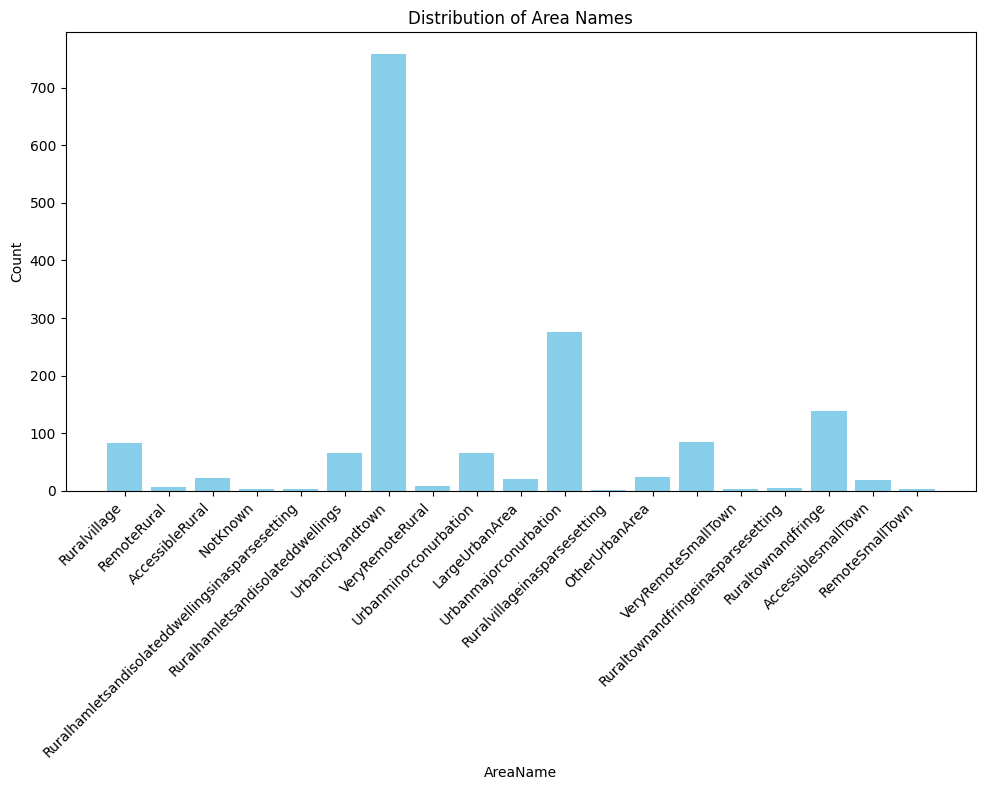

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, regexp_replace
import matplotlib.pyplot as plt
import pandas as pd

df = df.withColumn("AreaName", col("AreaName").cast("string"))
df = df.withColumn("AreaName_clean", when(col("AreaName").isNotNull(), regexp_replace(col("AreaName"), "\\s+", "")).otherwise(""))

# Basic analysis
total_rows = df.count()
print(f"Total rows: {total_rows}")
distinct_location_id_count = df.select("LocationId").distinct().count()
print(f"Distinct LocationId: {distinct_location_id_count}")

# Null value analysis across all columns
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
print(f"Null Counts:")
null_counts.show()

# Aggregation for plotting - based on cleaned 'AreaName'
area_name_counts = df.groupBy("AreaName_clean").count().toPandas()

# Plotting with matplotlib
plt.figure(figsize=(10, 8))
plt.bar(area_name_counts["AreaName_clean"], area_name_counts["count"], color='skyblue')
plt.xlabel('AreaName')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.title('Distribution of Area Names')
plt.tight_layout()
plt.show()

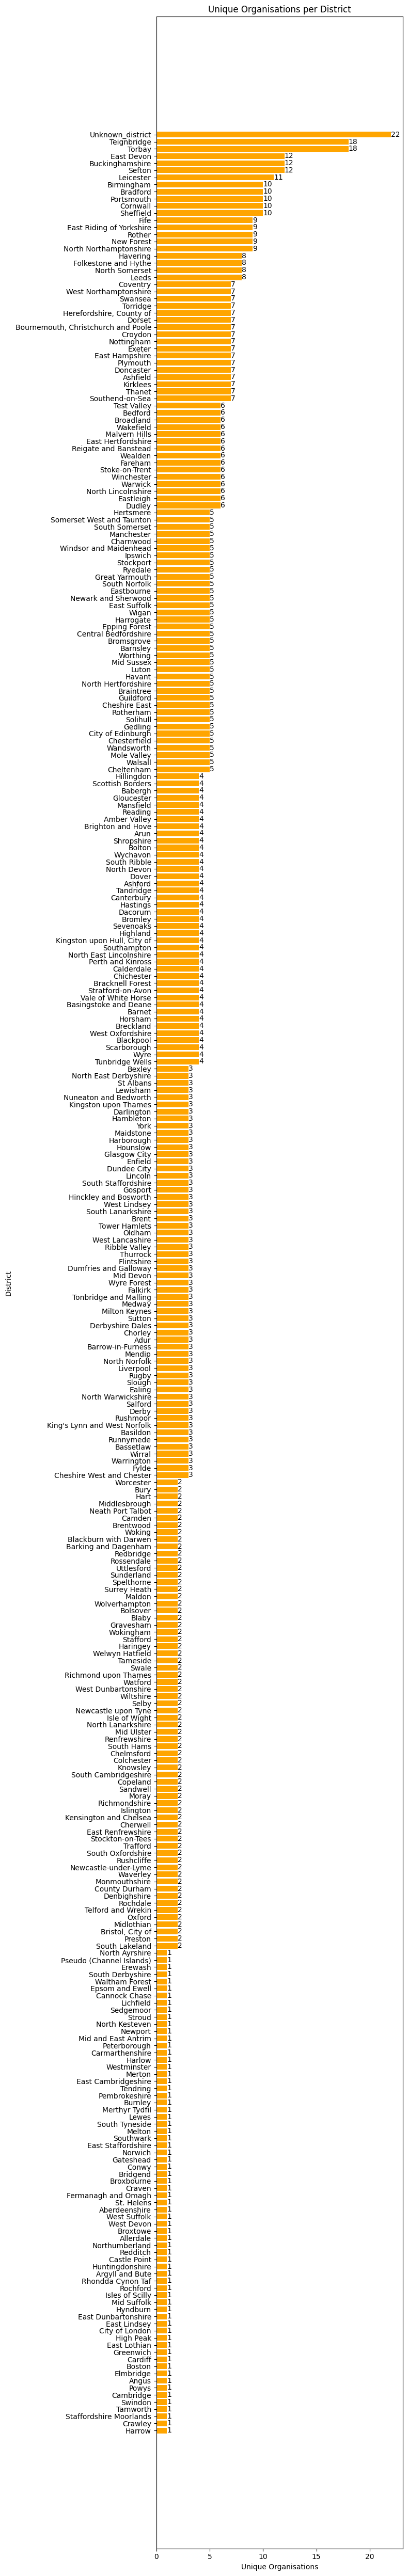

In [4]:
from pyspark.sql.functions import col, countDistinct
import matplotlib.pyplot as plt
import pandas as pd

df = df.withColumn("OrganisationID", col("OrganisationID").cast("string"))
df = df.withColumn("district", col("district").cast("string"))

df = df.na.fill({"OrganisationID": "Unknown_OrganisationID", "district": "Unknown_district"})

# Count unique organisations per district
unique_orgs_per_district = df.groupBy("district") \
                             .agg(countDistinct("OrganisationID").alias("unique_organisations")) \
                             .toPandas()

unique_orgs_per_district_sorted = unique_orgs_per_district.sort_values(by="unique_organisations", ascending=True)

# Plotting the unique organisations per district horizontally
plt.figure(figsize=(8, 50))  # Adjusted figure size for horizontal chart
bars = plt.barh(unique_orgs_per_district_sorted["district"], unique_orgs_per_district_sorted["unique_organisations"], color='orange')

# Add the data values to the bars
for bar in bars:
    plt.text(
        bar.get_width(),  # Get the horizontal placement for the text
        bar.get_y() + bar.get_height() / 2,  # Get the vertical placement for the text
        f'{bar.get_width()}',  # The text to display
        va='center',  # Center the text vertically in the bar
        ha='left',  # Align the text to the left of the bar
    )

plt.ylabel('District')
plt.yticks(fontsize=10)  # Adjust fontsize as needed for readability
plt.xlabel('Unique Organisations')
plt.title('Unique Organisations per District')
plt.tight_layout()
plt.show()
